# 데이터 준비

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

In [4]:
# 경고 메시지 무시
warnings.filterwarnings('ignore')

In [5]:
# Matplotlib 한글 폰트 설정 (Windows 버전)
# 윈도우 환경의 기본 한글 폰트인 'Malgun Gothic'으로 설정합니다.
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [6]:
# 1. 데이터 읽기
file_name = 'store_data.csv'
df = pd.read_csv(file_name, parse_dates=['주문 일자', '배송 일자'])
print(f"'{file_name}' 파일 로드 완료.\n")

'store_data.csv' 파일 로드 완료.



# 월별 신규 고객 유입 추이

--- 분석 1: 월별 신규 고객 유입 추이 ---


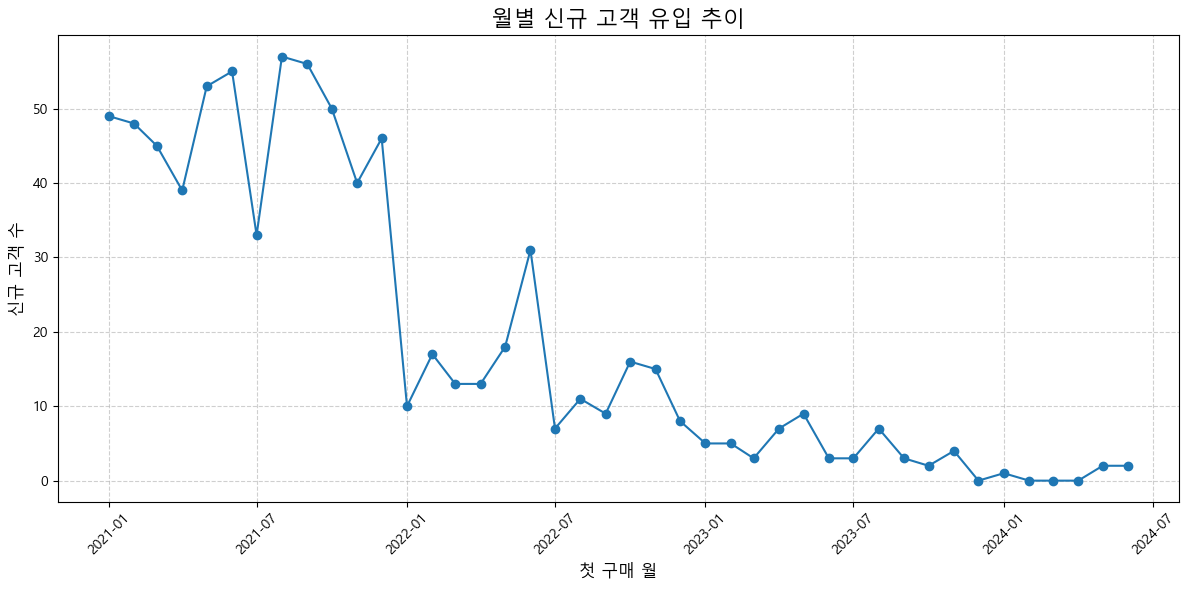

In [7]:
# --- 분석 1: 월별 신규 고객 유입 추이 (Line Chart) ---
print("--- 분석 1: 월별 신규 고객 유입 추이 ---")

# 1-1. 고객별 '첫 구매일' 찾기
customer_first_purchase = df.groupby('고객번호')['주문 일자'].min().reset_index()
customer_first_purchase = customer_first_purchase.rename(columns={'주문 일자': '첫 구매일'})

# 1-2. '첫 구매일'을 기준으로 월별 신규 고객 수 집계
monthly_new_customers = customer_first_purchase.set_index('첫 구매일').resample('MS')['고객번호'].count()
monthly_new_customers_df = monthly_new_customers.reset_index()
monthly_new_customers_df.columns = ['첫 구매 월', '신규 고객 수']


# 1-3. Matplotlib으로 선 차트 그리기
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(monthly_new_customers_df['첫 구매 월'], 
        monthly_new_customers_df['신규 고객 수'], 
        marker='o', linestyle='-')

ax.set_title('월별 신규 고객 유입 추이', fontsize=16)
ax.set_xlabel('첫 구매 월', fontsize=12)
ax.set_ylabel('신규 고객 수', fontsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 차트를 화면에 바로 표시
plt.show()

# 2차 구매 전환 분석

--- '2차 구매 전환 분석' 시작 ---

--- 1. 2차 구매 전환율 (전체 고객) ---
총 고객 수: 795 명
2차 구매 성공 고객 수: 788 명
2차 구매 전환율: 99.12%


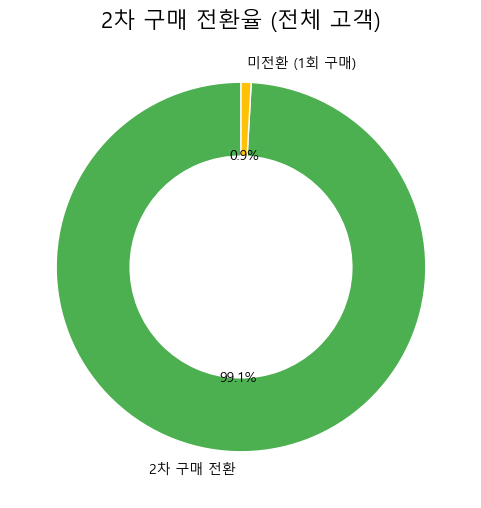

In [8]:
print("--- '2차 구매 전환 분석' 시작 ---")

# 2. 고객별 '주문 일자' 집계 (중복 제거)
# '고객번호'와 '주문 일자'의 고유한 조합을 찾습니다.
distinct_order_dates = df[['고객번호', '주문 일자']].drop_duplicates().sort_values(by=['고객번호', '주문 일자'])

# 3. 첫 번째 및 두 번째 구매일 찾기
# groupby().nth(n)을 사용하여 n번째 행을 효율적으로 찾습니다.
first_purchases = distinct_order_dates.groupby('고객번호').nth(0).reset_index().rename(columns={'주문 일자': '첫 구매일'})
second_purchases = distinct_order_dates.groupby('고객번호').nth(1).reset_index().rename(columns={'주문 일자': '두 번째 구매일'})

# 4. 데이터 병합 (첫 구매일 + 두 번째 구매일)
# '첫 구매일' 데이터(모든 고객)를 기준으로 '두 번째 구매일' 데이터를 'left' join 합니다.
# 2차 구매를 하지 않은 고객은 '두 번째 구매일'이 NaN 값으로 표시됩니다.
customer_journey_df = pd.merge(first_purchases, second_purchases, on='고객번호', how='left')

# 5. 2차 구매 전환율 계산
total_customers = len(customer_journey_df)
converted_customers = customer_journey_df['두 번째 구매일'].notna().sum() # NaN이 아닌(구매한) 고객 수
conversion_rate = converted_customers / total_customers

print("\n--- 1. 2차 구매 전환율 (전체 고객) ---")
print(f"총 고객 수: {total_customers} 명")
print(f"2차 구매 성공 고객 수: {converted_customers} 명")
print(f"2차 구매 전환율: {conversion_rate:.2%}")

# --- 시각화 1: 2차 구매 전환율 (도넛 차트) ---
plt.figure(figsize=(6, 6))
labels = ['2차 구매 전환', '미전환 (1회 구매)']
sizes = [converted_customers, total_customers - converted_customers]
colors = ['#4CAF50', '#FFC107'] # Green, Amber

# 파이 차트를 그리되, 'width'를 설정하여 도넛 차트로 만듭니다.
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
        wedgeprops=dict(width=0.4, edgecolor='w'))

# 가운데 원을 그려 도넛 모양을 완성합니다.
plt.gca().add_artist(plt.Circle((0,0), 0.6, fc='white'))

plt.title('2차 구매 전환율 (전체 고객)', fontsize=16)
plt.show() # Jupyter Notebook에서 바로 보기


--- 2. 2차 구매 소요 시간 (전환 성공 고객) ---
평균 소요 시간: 257.8 일
중앙값 소요 시간: 207 일 (중앙값이 분포를 보기에 더 좋습니다)

소요 시간 상세 통계:
count     788.000000
mean      257.789340
std       224.363816
min         1.000000
25%        91.000000
50%       207.000000
75%       356.500000
max      1365.000000
Name: 2차 구매 소요 시간(일), dtype: float64

(시각화 참고: 1년 이내 2차 구매 고객 597명 / 788명)


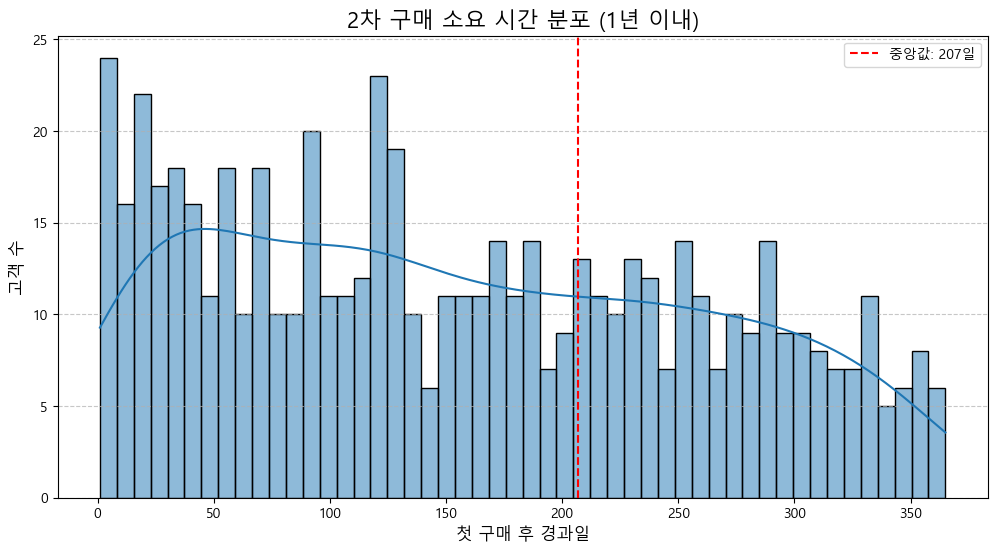


--- '2차 구매 전환 분석' 완료 ---


In [9]:
# --- 6. 2차 구매 소요 시간 분석 (전환 성공 고객 대상) ---
if converted_customers > 0:
    # 2차 구매에 성공한 고객들만 필터링
    converted_df = customer_journey_df.dropna(subset=['두 번째 구매일'])
    
    # '두 번째 구매일'과 '첫 구매일' 사이의 경과일(days) 계산
    converted_df['2차 구매 소요 시간(일)'] = (converted_df['두 번째 구매일'] - converted_df['첫 구매일']).dt.days
    
    # 소요 시간 통계
    median_time = converted_df['2차 구매 소요 시간(일)'].median()
    mean_time = converted_df['2차 구매 소요 시간(일)'].mean()
    
    print("\n--- 2. 2차 구매 소요 시간 (전환 성공 고객) ---")
    print(f"평균 소요 시간: {mean_time:.1f} 일")
    print(f"중앙값 소요 시간: {median_time:.0f} 일 (중앙값이 분포를 보기에 더 좋습니다)")
    
    print("\n소요 시간 상세 통계:")
    print(converted_df['2차 구매 소요 시간(일)'].describe())

    # --- 시각화 2: 2차 구매 소요 시간 (히스토그램) ---
    plt.figure(figsize=(12, 6))
    
    # 1년(365일) 이내에 재구매한 고객들만 따로 시각화 (너무 긴 꼬리 제외)
    plot_data = converted_df[converted_df['2차 구매 소요 시간(일)'] <= 365]
    
    sns.histplot(plot_data['2차 구매 소요 시간(일)'], bins=50, kde=True)
    
    plt.title('2차 구매 소요 시간 분포 (1년 이내)', fontsize=16)
    plt.xlabel('첫 구매 후 경과일', fontsize=12)
    plt.ylabel('고객 수', fontsize=12)
    
    # 중앙값(median)을 수직선으로 표시
    plt.axvline(median_time, color='red', linestyle='--', label=f'중앙값: {median_time:.0f}일')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    print(f"\n(시각화 참고: 1년 이내 2차 구매 고객 {len(plot_data)}명 / {converted_customers}명)")
    plt.show() # Jupyter Notebook에서 바로 보기

else:
    print("\n2차 구매에 성공한 고객이 없어 소요 시간 분석을 생략합니다.")

print("\n--- '2차 구매 전환 분석' 완료 ---")

# 신규 고객 제품 구매 및 지역 분석

In [10]:
# --- 분석 2: 신규 고객의 첫 구매 데이터 추출 ---
df_sorted = df.sort_values(by='주문 일자', ascending=True)
first_order_df = df_sorted.drop_duplicates(subset='고객번호', keep='first')

print(f"총 {len(first_order_df)}명의 신규 고객(첫 주문) 데이터 추출 완료.\n")


총 795명의 신규 고객(첫 주문) 데이터 추출 완료.



--- 분석 3: 신규 고객 첫 구매 제품 대분류 ---
제품 대분류
사무용품    448
가구      174
사무기기    173
Name: count, dtype: int64


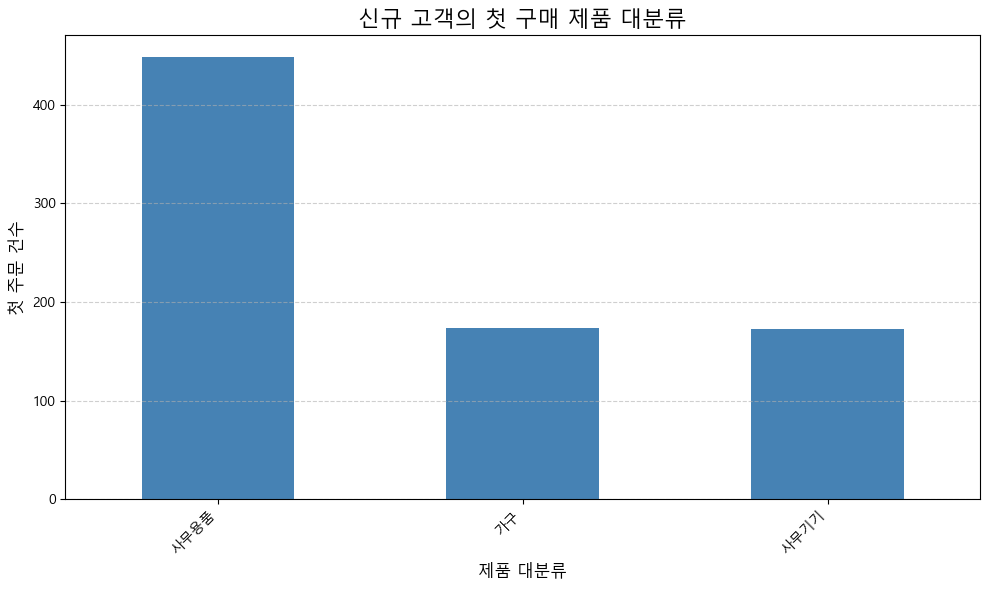

In [11]:
# --- 분석 3: 신규 고객의 첫 구매 제품 (Bar Chart) ---
print("--- 분석 3: 신규 고객 첫 구매 제품 대분류 ---")

# 3-1. 첫 구매 제품 대분류 집계
first_purchase_categories = first_order_df['제품 대분류'].value_counts()
print(first_purchase_categories)

# 3-2. Matplotlib으로 막대 차트 그리기
plt.figure(figsize=(10, 6))
first_purchase_categories.plot(kind='bar', color='steelblue')
plt.title('신규 고객의 첫 구매 제품 대분류', fontsize=16)
plt.xlabel('제품 대분류', fontsize=12)
plt.ylabel('첫 주문 건수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 차트를 화면에 바로 표시
plt.show()

--- 분석 4: 신규 고객 첫 구매 지역 (Top 10) ---
시도
경기도        168
서울특별시      155
부산광역시       50
전라남도        47
충청남도        45
경상북도        44
인천광역시       39
전라북도        37
강원도         36
충청북도        33
울산광역시       32
경상남도        28
대구광역시       25
대전광역시       23
광주광역시       18
제주특별자치도     11
세종특별자치시      4
Name: count, dtype: int64


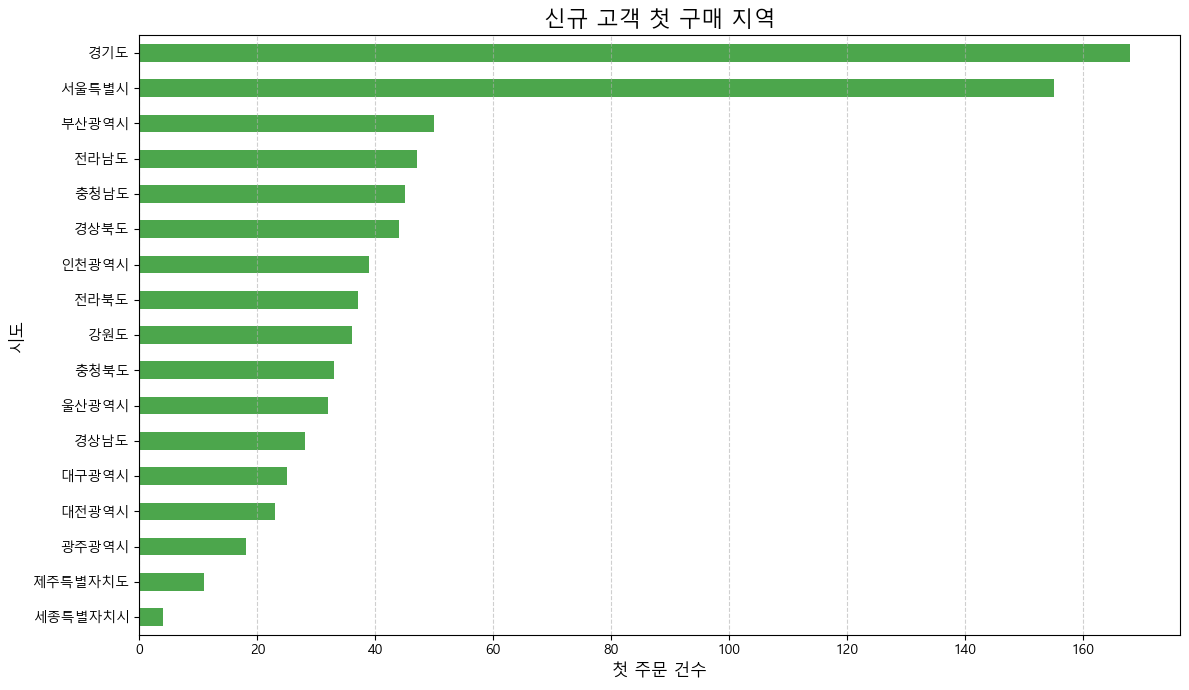

In [12]:
# --- 분석 4: 신규 고객 첫 구매 지역 (Bar Chart) ---
print("--- 분석 4: 신규 고객 첫 구매 지역 (Top 10) ---")

# 4-1. 첫 구매 지역 (Top 10) 집계
first_purchase_locations = first_order_df['시도'].value_counts()
print(first_purchase_locations)

# 4-2. Matplotlib으로 수평 막대 차트 그리기
plt.figure(figsize=(12, 7))
first_purchase_locations.sort_values().plot(kind='barh', color='green', alpha=0.7)
plt.title('신규 고객 첫 구매 지역', fontsize=16)
plt.xlabel('첫 주문 건수', fontsize=12)
plt.ylabel('시도', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# 차트를 화면에 바로 표시
plt.show()